# ECE/CS 434 | MP3: IMU PDR
<br />
<nav>
    <span class="alert alert-block alert-warning">Due at 11:59PM March 24th 2025 on Gradescope</span> |
</nav><br> 

**Name:** Heng An Cheng<br>
**NetID:** hacheng2

<hr />  

## Objective
In this MP, you will:
- Implement a step estimation algorithm using accelerometer data.
- Apply signal processing and linear algebra functions such as low/high pass filtering, peak detection, fft, etc. to the step estimation algorithm. 
- Track phone orientation through a sequence of gyroscope data by performing integration.
- Implement simple PDR algorithm: find the final position of the user using steps, orientations and initial position

---
## Problem Overview
In pedestrian dead-reckoning applications, two pieces of information need to be tracked: how far a user walked, and the direction of the walk. In the first part of this MP, you will derive the final orientation using a sequence of gyroscope data. In the second part, you will write a step estimation algorithm using accelerometer data as input and use it to calculate the final position of the user. 

---
## Imports & Setup

### Installing requirements correctly

First. we will make sure that the correct versions of required modules are installed. This ensures that your local Python environment is consistent with the one running on the Gradescope autograder. Just convert the following cell to code and run:

<div class="alert alert-block alert-info"><b>Note:</b> It's preferred that your local environment matches the autograder to prevent possible inconsistencies. However, if you're running into annoying Python version issues but haven't had any issues getting consistent results on the autograder, there is no need to stress over it. Just skip for now and come back when you do encounter inconsistencies:) Ditto below.
</div>

### Your imports
Write your import statements below. If Gradescope reports an error and you believe it is due to an unsupported import, check with the TA to see if it could be added.

In [84]:
import numpy as np
import pandas as pd
from pathlib import Path
import math

# This function is used to format test results. You don't need to touch it.
def display_table(data):
    from IPython.display import HTML, display

    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>{}</h4><td>".format(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

### Sanity-check

Running the following code block verifies that the correct module versions are indeed being used. 

Try restarting the Python kernel (or Jupyter) if there is a mismatch even after intalling the correct version. This might happen because Python's `import` statement does not reload already-loaded modules even if they are updated.

In [85]:
if __name__ == '__main__':
    from IPython.display import display, HTML

    def printc(text, color):
        display(HTML("<text style='color:{};weight:700;'>{}</text>".format(color, text)))

    _requirements = [r.split("==") for r in open(
        "requirements.txt", "r").read().strip().split("\n")]

    import sys
    for (module, expected_version) in _requirements:
        try:
            if sys.modules[module].__version__ != expected_version:
                printc("[✕] {} version should to be {}, but {} is installed.".format(
                    module, expected_version, sys.modules[module].__version__), "#f44336")
            else:
                printc("[✓] {} version {} is correct.".format(
                    module, expected_version), "#4caf50")
        except:
            printc("[–] {} is not imported, skipping version check.".format(
                module), "#03a9f4")

---
## Part 1. 3D Orientation Tracking

Assume that phone is static and phone's local coordinate frame and global/world coordinate frame are aligned at the initial moment. Perform gyro integration for each timestamp onward to calculate the phone's orientation. We will provide you with a trace of gyroscope data in CSV format. There are three columns in the file, representing the gyroscope readings in three **local** axes (unit: $rad / s$). The gyroscope is sampled at 100Hz. Your task is to track the phone’s 3D orientation and **output the end direction in which the phone’s local X axis is pointing at in the global frame**.

One way of solving this problem can be:
<ol type="A">
    <li> Assume the gyroscope’s sample interval is $\Delta t$. </li>
    <li> Get the phone's instant rotation axis and rotation angle in the local frame $(\vec{l}, \Delta \theta)$ for each time stamp $t_{i},$ where $\vec{l}=\left(\omega_{x}, \omega_{v}, \omega_{z}\right)$ and $\Delta \theta=\sqrt{\left(\omega_{x}^{2}+\omega_{v}^{2}+\omega_{z}^{2}\right)} \cdot \Delta t$ </li>
    <li> Project the instant rotation axis $\vec{l}$ into the global frame using the phone's $3 \mathrm{D}$ orientation matrix $R_{i}$ at time $t_{i}$. </li>
    <li> Convert the instant rotation axis and angle in global frame into the form of rotation matrix $\Delta R_{i}$. </li>
    <li> Find the total 3D rotation matrix for time $t_{i+1}: R_{i+1}=\Delta R_{i} \cdot R_{i}$ </li>
</ol>

--- 
**Implement the above algorithm in `track_orientation(gyro_file)` below.** 

Do <b>NOT</b> change the function signature. You are, however, free to define and use helper functions.

In [86]:
# This function takes 1 argument:
#     - gyro_file (string) - name of file containing a sequence of gyroscope data
# It returns an array representing the final global direction
# in which the phone's local X axis is pointing.

# The gyro_file is a CSV file containing a sequence of gyroscope data.

# Rodrgues’ rotation formula is used to update the orientation of the phone.
def axis_angle_to_rotation_matrix(axis, angle):
    c = np.cos(angle)
    s = np.sin(angle)
    t = 1 - c

    x = axis[0]
    y = axis[1]
    z = axis[2]

    return np.array([[t*x*x + c, t*x*y - z*s, t*x*z + y*s],
                     [t*x*y + z*s, t*y*y + c, t*y*z - x*s],
                     [t*x*z - y*s, t*y*z + x*s, t*z*z + c]])

def track_orientation(gyro_file):
    # Your implementation starts here:
    gyro = pd.read_csv(gyro_file)
    gyro_data = gyro.values
    dt = 0.01  # 100 Hz sampling rate

    R = np.eye(3)  # Initial orientation (identity matrix)

    for omega in gyro_data:
        angle = np.linalg.norm(omega) * dt
        if(angle > 1e-8):
            axis_local = omega / np.linalg.norm(omega)
            axis_global = R @ axis_local
            dR = axis_angle_to_rotation_matrix(axis_global, angle)
            R = dR @ R
    
    local_x_axis_in_global = R @ np.array([1, 0, 0])
    return local_x_axis_in_global
track_orientation('orient_data/gyro.csv')

array([-0.03729062,  0.98638029, -0.16019777])

### Run & Test
Use the cell below to run and test Part 1.

In [87]:
def get_deviation(calculated, expected):
    calculated = np.array(calculated)
    expected = np.array(expected)
    with np.errstate(divide='ignore', invalid='ignore'):
        dot_prod = np.dot(calculated, expected) / \
            np.linalg.norm(calculated) / np.linalg.norm(expected)
        return np.degrees(np.arccos(dot_prod))


if __name__ == '__main__':
    gt_final = [-0.03729062, 0.98638029, -0.16019777]
    stu_final = track_orientation('orient_data/gyro.csv')
    output = [['Test', 'Dataset', 'Expected Output',
               'Your Output', 'Deviation', 'Result', 'Grade']]
    final_state = 'FAILED'
    final_grade = 0
    final_dev = get_deviation(stu_final, gt_final)
    if(final_dev < 2):
        final_state = 'PASSED'
        final_grade = 10
    output.append(['Final Orientation', 'gyro.csv',
                  gt_final, stu_final, "{:2.2f}°".format(final_dev), final_state, "{} / 10".format(final_grade)])
    output.append(['<i>👻 Hidden test 1 👻</i>','<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i> / 10'])
    output.append(['<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>'])
    output.append(['<i>👻 Hidden test 4 👻</i>','<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i> / 10'])
    display_table(output)

---
## Part 2. Step Estimation
We have provided you with smartphone accelerometer data collected under three circumstances
<ol type="A">
  <li>walking with phone in pant pocket</li>
  <li>walking with phone held in the hand statically as if the user is looking at it while walking</li>
  <li>walking with phone in hand and the hand swinging</li>
</ol>

there are three columns, representing the accelerometer readings in three local axes(unit: $m / s^{2}$). The accelerometer is sampled at 100Hz.

Implement your algorithm in the `calculate_steps(accl_data)` and `calculate_final_position(steps_with_walking_direction, start_position)` functions below. Do NOT change the function signatures. You are, however, free to define and use helper functions. You are expected to use common signal processing and linear algebra functions (e.g., high/low pass filtering, convolution, cross correllation, peak detection, fft etc.) 

<b>TIP:</b> It may help to first visualize the accelerometer data like you did in MP1.

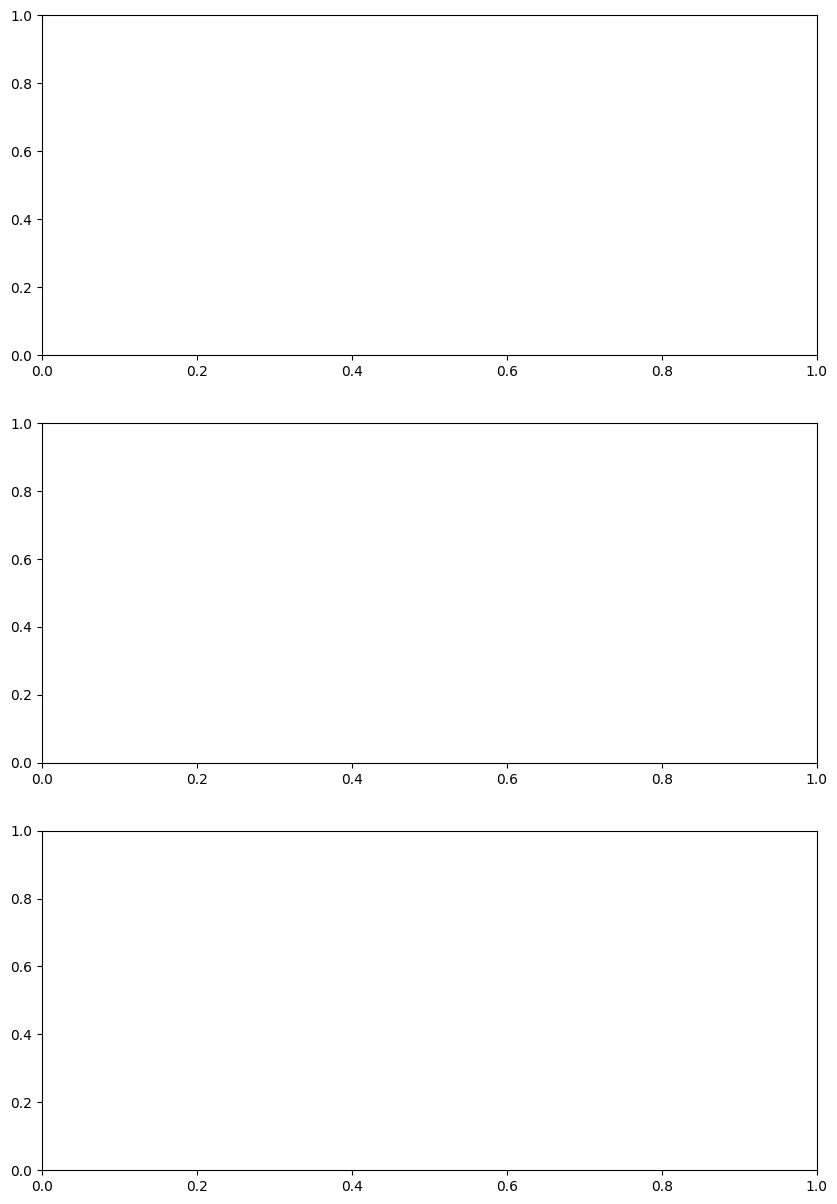

In [88]:
import matplotlib.pyplot as plt
# read the data
folder = 'accel_data/'
a_data = pd.read_csv(folder+'holdstatic_20steps.csv')
b_data = pd.read_csv(folder+'inpocket_36steps.csv')
c_data = pd.read_csv(folder+'swing_32steps.csv')

# Create subplots for each dataset
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

def plot_data(ax, data, title):
    ax.plot(data.index, data.iloc[:, 0], label='x')
    ax.plot(data.index, data.iloc[:, 1], label='y')
    ax.plot(data.index, data.iloc[:, 2], label='z')
    ax.plot(data.index, np.linalg.norm(data[['x', 'y', 'z']].values, axis=1), label='norm', linestyle='--')
    ax.set_xlabel('Time')
    ax.set_ylabel('Acceleration ($m/s^2$)')
    ax.set_title(title)
    ax.legend()
#plot_data(axs[0], a_data, 'holdstatic_20steps.csv')
#plot_data(axs[1], b_data, 'inpocket_36steps.csv')
#plot_data(axs[2], c_data, 'swing_32steps.csv')

# Adjust layout
#plt.tight_layout()
#plt.show()

In [89]:
import numpy as np
import scipy.signal as signal
def get_step_length():
    """
    step length is approximated to be proportional to the height of pedestrian
    """
    height=1.75 # in meters
    return 0.415*height


def calculate_steps(accl_data):
    """
    :param accel_data: pandas dataframe with 3 columns, "x", "y", "z" representing acceleration in m/s^2 
    and index of dataframe is "timestamp"
    
    returns: pandas dataframe with 2 columns "timestamp" and "steplength" 
    
    for this MP assume that the step length is same for each step, 
    use the get_step_length function to get the step length
    
    the timestamp is the time when the step is detected
    
    NOTE: timestamps should be among the values in the timestamp column, 
    you are not expected to do any time interpolation
    """
    # Step 1: acc magnitude
    a_mag = np.linalg.norm(accl_data[['x', 'y', 'z']].values, axis=1)
    timestamps = accl_data.index.values

    # Step 2: high-pass filter to remove gravity
    b, a = signal.butter(2, 0.5 / 50, 'high')  # 0.5 Hz cut-off, fs = 100 Hz
    a_mag_hp = signal.filtfilt(b, a, a_mag)

    # Step 3: moving average filter to smooth the signal and remove noise
    window_size = 20
    a_mag_smooth = np.convolve(a_mag_hp, np.ones(window_size) / window_size, mode='same')

    # Step 4: peak detection
    peaks, _ = signal.find_peaks(
        a_mag_smooth,
        prominence=1.0,   
        distance=20,      
        height=0.5 
    )
    steps_df = pd.DataFrame({
        'timestamp': timestamps[peaks],
        'steplength': get_step_length()
    })
    #print(steps_df)
    return steps_df

def calculate_final_position(steps_with_walking_direction, start_position):
    """ 
    :param steps_with_walking_direction: pandas dataframe with 3 columns "timestamp", "steplength", and "walking_direction"
    
    walking_direction is an angle in degrees with global frame x-axis. It can be from 0 degrees to 360 degrees.
    for e.g. if walking direction is 90 degrees, user is walking in the positive y-axis direction
    
    NOTE: In the given test cases, the walking direction is same through out the trajectory 
    but in hidden cases the walking direction may change
    
    step_length is in meters
    
    :param start_position: starting position of the user. It is tuple (x,y)
    
    return (x,y) coordinate of the final position in meters
    """
    step_length = get_step_length()  # meters
    
    directions = steps_with_walking_direction['walking_direction'].astype(float).values/180*np.pi
    dx_all = step_length * np.cos(directions)
    dy_all = step_length * np.sin(directions)
    x = dx_all.sum().astype(float)+start_position[0]
    y = dy_all.sum().astype(float)+start_position[1]

    return (x, y)

### Run & Test
Use the cell below to run and test `calculate_steps(accl_data)` and `calculate_final_position(steps_with_walking_direction, start_position)`. 

In [90]:
def estimate_steps_score(calculated, expected):
    delta = abs(calculated - expected)
    return 1 if(delta <= 2) else max((1 - abs(delta - 2) / expected), 0)

def estimate_pdr_score(calculated, expected):
    error = math.sqrt((calculated[0] - expected[0])**2 + (calculated[1] - expected[1])**2)
    # error more than 5 meters, score is 0
    return 1.0 if (error <= 2.0) else max(0, 1-(error-2.0)/3)


if __name__ == '__main__':
    data_dir = "accel_data"
    walk_accl_files = ['holdstatic_20steps.csv', 'inpocket_26steps.csv',
                       'inpocket_36steps.csv', 'swing_32steps.csv', 'swing_38steps.csv']
    groundtruth_numsteps = [20, 26, 36, 32, 38]
    groundtruth_final_positions = [(12.58, 7.26), (18.88, 0.0), (0.0, 26.14), (-23.24, 0.0), (0.0, -27.6)]
    output = [['Dataset', 'Expected Number Steps', 'Your Number of Steps', 'Expected Final Position', 'Your Final Position', 'Grade']]
    for i in range(len(groundtruth_numsteps)):
        accel_data = pd.read_csv(str(Path(data_dir) / walk_accl_files[i]))
        accel_data = accel_data.set_index("timestamp", drop=True)
        calculated = calculate_steps(accel_data)
        assert len(calculated.columns)==2
        assert "timestamp" in calculated.columns
        assert "steplength" in calculated.columns
        calculated_num_steps = calculated.shape[0]
        calculated["walking_direction"] = accel_data["walking_direction"][calculated["timestamp"]].values
        calculated_final_position = calculate_final_position(calculated, (0.0,0.0))
        steps_score = estimate_steps_score(calculated_num_steps, groundtruth_numsteps[i])
        pdr_score = estimate_pdr_score(calculated_final_position, groundtruth_final_positions[i])
        # final score is weighted sum of both scores
        score = 0.7*steps_score + 0.3*pdr_score
        output.append([walk_accl_files[i], groundtruth_numsteps[i],
                      calculated_num_steps, groundtruth_final_positions[i], calculated_final_position,  "{:2.2f} / 5.00".format(score * 5)])
    output.append(['<i>👻 Hidden test 1 👻</i>','<i>???</i>', '<i>???</i>','<i>???</i>', '<i>???</i>', '<i>???</i> / 15.00'])
    output.append(['<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>'])
    output.append(['<i>👻 Hidden test 5 👻</i>','<i>???</i>', '<i>???</i>','<i>???</i>', '<i>???</i>', '<i>???</i> / 15.00'])
    display_table(output)

---
## Rubric

####  Orientation Tracking (100 points) 
You will be graded on the provided data as well as 4 addition sets of data. They are each worth 20 points. A 2-degree error is tolerated. For results greater than the error threshold, no points will be rewarded since we provided a detailed algorithm to follow. The test data also include the simple case where the phone will only rotate along Z axis onwards. (In case you find the MP too difficult, only doing 1D integration on Z axis should at least give you some points.)

#### Step Estimation (100 points) 
You will be graded on the 5 sets of provided data (5 points each), as well as 5 sets of hidden data (15 points each). For each test case, the grade depends on how much the result deviates from the groudtruth. A 2-step error for the provided data is tolerated. A 4-step error for the hidden data is tolerated. For results greater than the error threshold, your score will be scaled proportionally. The score is the weighted sum of PDR error i.e., deviation from the final position and the step count detection accuracy.

---
## Submission Guideline
This Jupyter notebook is the only file you need to submit on Gradescope. Make sure to fill your name at the top of this file.

**Make sure any code you added to this notebook, except for import statements, is either in a function or guarded by `__main__`(which won't be run by the autograder). Gradescope will give you immediate feedback using the provided test cases. It is your responsibility to check the output before the deadline to ensure your submission runs with the autograder.**